# 20.6 — Batch Weibull Analysis (Fleet / Populations)

This notebook extends **Chapter 20.5** by running Weibull fits **across multiple asset populations** (e.g., Asset_Type, Location, Failure_Mode).

✅ Designed to run in **Google Colab**  
✅ Produces **copy-ready figures** (saved to `figures/`)  
✅ Generates a **results table** you can paste into the book

> Dataset required: `Failure_Events_CLEAR_Enhanced.xlsx`


## 0) Install dependencies (Colab)

In [4]:
# If running in Google Colab, uncomment and run once:
!pip install "numpy<2.0"
!pip -q install reliability openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.2
    Uninstalling numpy-2.4.2:
      Successfully uninstalled numpy-2.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
reliability 0.9.0 requires numpy>=2.2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 w

ERROR: Operation cancelled by user
^C


## 1) Upload dataset (Colab)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Failure_Events_CLEAR_Enhanced.xlsx to Failure_Events_CLEAR_Enhanced (1).xlsx


## 2) Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from reliability.Fitters import Fit_Weibull_2P

## 3) Load dataset

In [3]:
DATA_FILE = "Failure_Events_CLEAR_Enhanced.xlsx"
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"{DATA_FILE} not found. Upload it first or place it in the working directory.")

df = pd.read_excel(DATA_FILE)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head(5)

Rows: 180
Columns: ['Plant', 'Event_ID', 'Asset_ID', 'Event_Type', 'Failure_Start', 'Detection_Time', 'Repair_Start', 'Return_To_Service', 'Downtime_hr', 'Planned_Flag', 'Production_Impact', 'Failure_Mode_Code', 'Failure_Mode_Text', 'Cause_Code', 'Cause_Category', 'Action_Code', 'Action_Category', 'Parts_Used_Flag', 'WorkOrder_ID', 'Comments', 'Data_Quality_Flag', 'Component_Code', 'Location_Code', 'Event_Code', 'Agent_Code', 'Response_Code', 'CLEAR_Code']


,Plant,Event_ID,Asset_ID,Event_Type,...,Event_Code,Agent_Code,Response_Code,CLEAR_Code
0,Alpha Process Plant,EV-2024-000001,MTR-302,FAILURE,...,OHT,OPR,REP,UNK-DE-OHT-OPR-REP
1,Alpha Process Plant,EV-2024-000002,PMP-107,FAILURE,...,UNK,UNK,RPL,UNK-SUC-UNK-UNK-RPL
2,Alpha Process Plant,EV-2024-000003,CV-409,TRIP,...,UNK,MEC,REP,UNK-DE-UNK-MEC-REP
3,Alpha Process Plant,EV-2024-000004,PMP-101A,FAILURE,...,UNK,OPR,ADJ,UNK-NDE-UNK-OPR-ADJ
4,Alpha Process Plant,EV-2024-000005,PMP-104,FAILURE,...,LEK,MEC,RPL,SEA-DE-LEK-MEC-RPL


## 4) Choose a grouping column (population definition)

Batch Weibull requires a definition of *populations* you want to compare.  
Common grouping columns include:

- `Asset_Type` (Pump vs Motor vs Valve)
- `Asset_Class`
- `Location_Code` (Site A vs Site B)
- `System` / `Area`
- `Failure_Mode_Code` (Bearing wear vs Seal leak)

### How this notebook works
- Set `GROUP_COL` to a column name
- If it doesn't exist, the notebook will show likely alternatives.


In [5]:
# === EDIT THIS ===
GROUP_COL = "Failure_Mode_Code"   # e.g., "Asset_Type", "Location_Code", "Failure_Mode_Code", "Asset_Class"

# Failure-like events used to define intervals
FAILURE_EVENTS = {"FAILURE", "TRIP"}  # edit if needed

# Minimum failures per group required to fit Weibull
MIN_FAILURES_PER_GROUP = 8

print("Requested GROUP_COL:", GROUP_COL)
print("Available columns:", df.columns.tolist())

if GROUP_COL not in df.columns:
    candidates = [c for c in df.columns if any(k in c.lower() for k in ["type","class","loc","site","area","system","failure_mode","mode"])]
    raise ValueError(
        f"GROUP_COL '{GROUP_COL}' not found.\n"
        f"Try one of these likely candidates: {candidates}"
    )

Requested GROUP_COL: Failure_Mode_Code
Available columns: ['Plant', 'Event_ID', 'Asset_ID', 'Event_Type', 'Failure_Start', 'Detection_Time', 'Repair_Start', 'Return_To_Service', 'Downtime_hr', 'Planned_Flag', 'Production_Impact', 'Failure_Mode_Code', 'Failure_Mode_Text', 'Cause_Code', 'Cause_Category', 'Action_Code', 'Action_Category', 'Parts_Used_Flag', 'WorkOrder_ID', 'Comments', 'Data_Quality_Flag', 'Component_Code', 'Location_Code', 'Event_Code', 'Agent_Code', 'Response_Code', 'CLEAR_Code']


## 5) Validate required columns and parse timestamps

In [6]:
required_cols = ["Asset_ID", "Event_Type", "Failure_Start", GROUP_COL]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["Failure_Start"] = pd.to_datetime(df["Failure_Start"], errors="coerce")
df = df.dropna(subset=["Failure_Start", "Asset_ID"]).copy()

# Normalize grouping values
df[GROUP_COL] = df[GROUP_COL].astype(str).str.strip()
df.loc[df[GROUP_COL].isin(["", "nan", "None"]), GROUP_COL] = "UNKNOWN"

df[required_cols].head(10)

,Asset_ID,Event_Type,Failure_Start,Failure_Mode_Code
0,MTR-302,FAILURE,2023-01-16 18:24:10,FM-MTR-UNB-01
1,PMP-107,FAILURE,2023-01-24 19:25:54,FM-PMP-IMP-01
2,CV-409,TRIP,2023-01-26 14:28:00,FM-CV-CAV-01
3,PMP-101A,FAILURE,2023-01-30 18:13:43,FM-PMP-CAV-01
4,PMP-104,FAILURE,2023-01-31 22:32:44,FM-PMP-SEA-01
5,PMP-109,TRIP,2023-02-01 09:18:25,FM-PMP-SEA-01
6,MTR-303,FAILURE,2023-02-04 02:12:08,FM-MTR-BRG-01
7,TX-508,FAILURE,2023-02-08 11:35:01,FM-INS-NOI-01
8,MTR-311,TRIP,2023-02-08 20:40:53,FM-MTR-BRG-01
9,CV-408,FAILURE,2023-03-03 18:16:51,FM-CV-AIR-01


## 6) Derive TTF intervals per asset, while keeping group membership

We compute TTF as the time between consecutive failure-like events per asset.  
Each interval inherits the asset's `GROUP_COL` value.

Right-censoring is computed as:
- `OBS_END - last_failure_timestamp` per asset (assigned to the same group)


In [7]:
# Filter failure-like events
df_fail = df[df["Event_Type"].astype(str).str.upper().isin(FAILURE_EVENTS)].copy()
df_fail["Event_Type"] = df_fail["Event_Type"].astype(str).str.upper()

# Sort and compute intervals per asset
df_fail = df_fail.sort_values(["Asset_ID", "Failure_Start"])
df_fail["TTF_hours"] = df_fail.groupby("Asset_ID")["Failure_Start"].diff().dt.total_seconds() / 3600.0

# Intervals (failures)
intervals = df_fail.dropna(subset=["TTF_hours"]).copy()
intervals = intervals[intervals["TTF_hours"] > 0]
intervals = intervals[["Asset_ID", GROUP_COL, "TTF_hours"]].copy()

print("Total derived failure intervals:", len(intervals))
intervals.head(10)

Total derived failure intervals: 113


,Asset_ID,Failure_Mode_Code,TTF_hours
61,CMP-201A,FM-CMP-OHT-01,7719.41
134,CMP-203,FM-CMP-VIB-01,11123.7
141,CMP-203,FM-CMP-INT-01,1102.94
156,CMP-204,FM-CMP-LKG-01,6992.57
47,CMP-205B,FM-CMP-VIB-01,1413.83
80,CMP-205B,FM-CMP-OIL-01,3861.64
102,CMP-206B,FM-CMP-SRG-01,3630.22
125,CMP-206B,FM-CMP-SRG-01,3224.72
173,CMP-206B,FM-CMP-OHT-01,6848.73
25,CV-401,FM-CV-LEK-01,507.341


In [8]:
# Right-censoring (recommended)
OBS_END = df["Failure_Start"].max()

# Map each asset to its group (most frequent non-UNKNOWN)
asset_group = df[["Asset_ID", GROUP_COL]].groupby("Asset_ID")[GROUP_COL].agg(lambda s: s.value_counts().index[0])

last_fail = df_fail.groupby("Asset_ID")["Failure_Start"].max()

right_censored = (OBS_END - last_fail).dt.total_seconds() / 3600.0
right_censored = right_censored[right_censored > 0].to_frame("RC_hours")

right_censored[GROUP_COL] = right_censored.index.map(asset_group)
right_censored[GROUP_COL] = right_censored[GROUP_COL].fillna("UNKNOWN").astype(str)

print("Total right-censored intervals:", len(right_censored))
right_censored.head(10)

Total right-censored intervals: 48


,RC_hours,Failure_Mode_Code
Asset_ID,,
CMP-201A,15471.2,FM-CMP-OIL-01
CMP-203,4548.21,FM-CMP-OHT-01
CMP-204,2456.83,FM-CMP-INT-01
CMP-205B,13807.5,FM-CMP-SRG-01
CMP-206B,779.074,FM-CMP-SRG-01
CV-401,1857.37,FM-CV-LEK-01
CV-402,5185.16,FM-CV-TRV-01
CV-403,1212.5,FM-CV-LEK-01
CV-404,7752.6,FM-CV-STI-01


## 7) Fit Weibull per group and build a results table

We pool intervals within each group and fit Weibull(β, η).  
Groups with fewer than `MIN_FAILURES_PER_GROUP` failures are skipped to avoid unstable fits.


In [9]:
results = []
fits = {}

groups = sorted(intervals[GROUP_COL].unique())

for g in groups:
    f = intervals.loc[intervals[GROUP_COL] == g, "TTF_hours"].values
    rc = right_censored.loc[right_censored[GROUP_COL] == g, "RC_hours"].values if len(right_censored) else np.array([])

    n_fail = len(f)
    n_rc = len(rc)

    if n_fail < MIN_FAILURES_PER_GROUP:
        results.append({
            GROUP_COL: g,
            "n_failures": n_fail,
            "n_right_censored": n_rc,
            "beta": np.nan,
            "eta_hours": np.nan,
            "note": f"Skipped (n_failures < {MIN_FAILURES_PER_GROUP})"
        })
        continue

    fit = Fit_Weibull_2P(failures=f, right_censored=rc, show_probability_plot=False)
    fits[g] = fit

    results.append({
        GROUP_COL: g,
        "n_failures": n_fail,
        "n_right_censored": n_rc,
        "beta": float(fit.beta),
        "eta_hours": float(fit.alpha),
        "AICc": float(getattr(fit, "AICc", np.nan)),
        "BIC": float(getattr(fit, "BIC", np.nan)),
        "AD": float(getattr(fit, "AD", np.nan)),
        "note": "OK"
    })

res = pd.DataFrame(results).sort_values(["note", "n_failures"], ascending=[True, False]).reset_index(drop=True)
res

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 8/2 (20% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         6350.15         2192.63   3227.56   12493.8
     Beta         1.04738        0.289365   0.60945   1.79999 

Goodness of fit    Value
 Log-likelihood -77.9418
           AICc  161.598
            BIC  160.489
             AD  2.47952 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 10/4 (28.57143% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         3867.46         809.888   2565.51   5830.11
     Beta         1.52318        0.349412  0.971606   2.38789 

Goodness of fit    Value
 Log-likelihood -91.2052
           AICc  187.501
            BIC  187.689
             AD  3.00417 

Results from Fit_Weibull_2P (95% CI):
Analy

,Failure_Mode_Code,n_failures,n_right_censored,beta,eta_hours,note,AICc,BIC,AD
0,FM-PMP-BRG-01,10,4,1.52318,3867.46,OK,187.501,187.689,3.00417
1,FM-CV-LEK-01,8,2,1.04738,6350.15,OK,161.598,160.489,2.47952
2,FM-PMP-SEA-01,8,3,1.33426,8663.27,OK,166.044,165.34,2.69421
3,FM-MTR-TERM-01,7,1,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN
4,FM-PMP-DRY-01,7,1,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN
5,FM-PMP-CAV-01,6,5,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN
6,FM-CV-TRV-01,5,1,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN
7,FM-INS-DRF-01,5,5,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN
8,FM-MTR-BRG-01,5,2,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN
9,FM-MTR-OVL-01,5,1,NaN,NaN,Skipped (n_failures < 8),NaN,NaN,NaN


### Save results table

In [10]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

res_path = os.path.join(OUT_DIR, f"batch_weibull_results_by_{GROUP_COL}.csv")
res.to_csv(res_path, index=False)
print("Saved:", res_path)

Saved: outputs/batch_weibull_results_by_Failure_Mode_Code.csv


## 8) Plot: Compare Reliability Curves across groups

Overlay R(t) for all fitted groups on one chart (book-friendly).


Saved: figures/WBL_20_5B_Reliability_Compare_Failure_Mode_Code.png


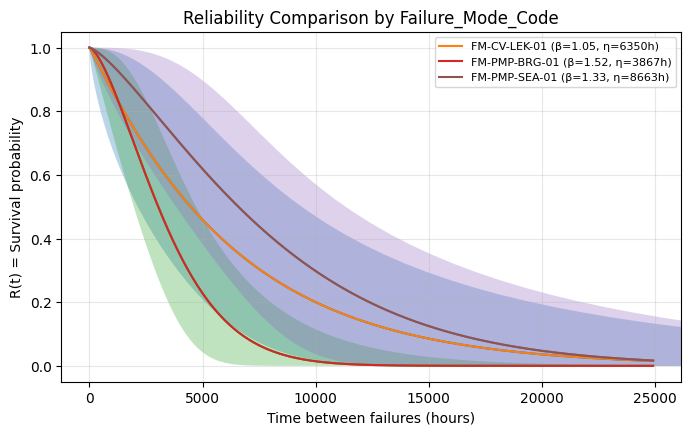

In [11]:
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

x_max = max(intervals["TTF_hours"].max(), right_censored["RC_hours"].max() if len(right_censored) else 0)
x = np.linspace(0.0, x_max * 1.10, 600)

plt.figure(figsize=(8,5))
for g, fit in fits.items():
    y = fit.distribution.SF(x)
    plt.plot(x, y, label=f"{g} (β={fit.beta:.2f}, η={fit.alpha:.0f}h)")

plt.xlabel("Time between failures (hours)")
plt.ylabel("R(t) = Survival probability")
plt.title(f"Reliability Comparison by {GROUP_COL}")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8, ncol=1, loc="best")

fig_path = os.path.join(FIG_DIR, f"WBL_20_5B_Reliability_Compare_{GROUP_COL}.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print("Saved:", fig_path)
plt.show()

## 9) Plot: β and η across groups (quick diagnostic)

Higher β → stronger wear-out tendency.  
Lower η → shorter characteristic life (faster deterioration / harsher operation).


Saved: figures/WBL_20_5B_Beta_by_Failure_Mode_Code.png


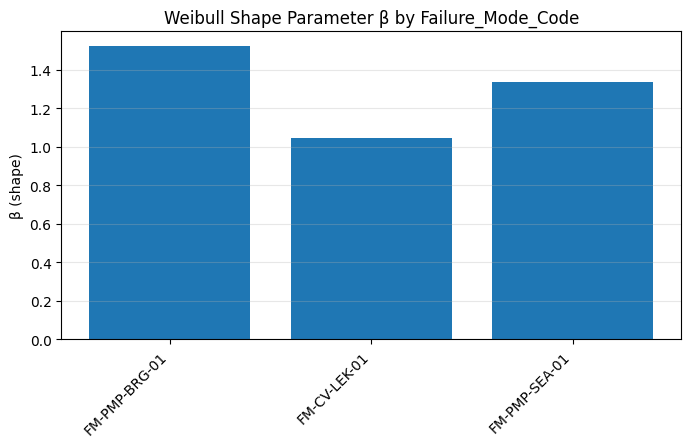

Saved: figures/WBL_20_5B_Eta_by_Failure_Mode_Code.png


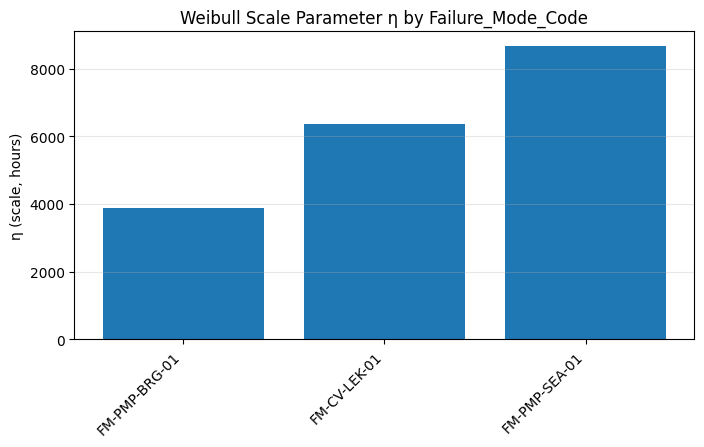

In [12]:
fit_only = res[res["note"] == "OK"].copy()

plt.figure(figsize=(8,4))
plt.bar(fit_only[GROUP_COL], fit_only["beta"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("β (shape)")
plt.title(f"Weibull Shape Parameter β by {GROUP_COL}")
plt.grid(True, axis="y", alpha=0.3)
beta_path = os.path.join(FIG_DIR, f"WBL_20_5B_Beta_by_{GROUP_COL}.png")
plt.savefig(beta_path, dpi=300, bbox_inches="tight")
print("Saved:", beta_path)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(fit_only[GROUP_COL], fit_only["eta_hours"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("η (scale, hours)")
plt.title(f"Weibull Scale Parameter η by {GROUP_COL}")
plt.grid(True, axis="y", alpha=0.3)
eta_path = os.path.join(FIG_DIR, f"WBL_20_5B_Eta_by_{GROUP_COL}.png")
plt.savefig(eta_path, dpi=300, bbox_inches="tight")
print("Saved:", eta_path)
plt.show()

## 10) Optional: Save probability plots per group

Saved as individual PNG files (useful for appendix).


array([0.        , 0.00010874, 0.00013849, 0.00014309, 0.00014586,
       0.00014786, 0.00014943, 0.00015072, 0.00015182, 0.00015279,
       0.00015364, 0.00015441, 0.00015511, 0.00015575, 0.00015634,
       0.00015689, 0.0001574 , 0.00015789, 0.00015834, 0.00015877,
       0.00015918, 0.00015956, 0.00015993, 0.00016029, 0.00016062,
       0.00016095, 0.00016126, 0.00016156, 0.00016185, 0.00016213,
       0.0001624 , 0.00016266, 0.00016291, 0.00016316, 0.00016339,
       0.00016362, 0.00016385, 0.00016407, 0.00016428, 0.00016449,
       0.00016469, 0.00016489, 0.00016508, 0.00016527, 0.00016546,
       0.00016564, 0.00016581, 0.00016598, 0.00016615, 0.00016632,
       0.00016648, 0.00016664, 0.0001668 , 0.00016695, 0.0001671 ,
       0.00016725, 0.0001674 , 0.00016754, 0.00016768, 0.00016782,
       0.00016795, 0.00016809, 0.00016822, 0.00016835, 0.00016848,
       0.0001686 , 0.00016873, 0.00016885, 0.00016897, 0.00016909,
       0.0001692 , 0.00016932, 0.00016943, 0.00016955, 0.00016

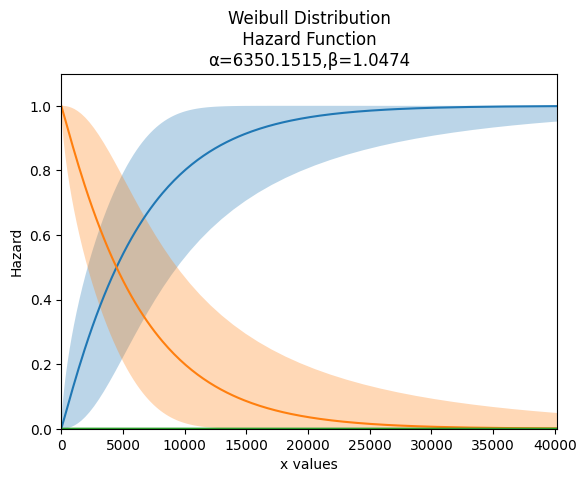

In [15]:
fit.distribution.CDF()
fit.distribution.SF()
fit.distribution.HF()


## Interpretation notes (copy into your manuscript)

**What this notebook models**
- Each group is treated as a *population* (pooled life data).
- Life data per group are the derived **time-between-failure intervals** across all assets in that group.

**How to interpret differences**
- Higher **β** → stronger wear-out tendency (aging dominates).
- Lower **η** → shorter characteristic interval (faster deterioration / harsher operation).
- Compare **R(t)** curves at a common planning horizon to quantify operational risk.

**What to do next**
- If one group is clearly worse, drill down by:
  - Failure_Mode_Code (mechanism)
  - Location / duty cycle
  - Maintenance strategy / PM compliance


## (Colab) Download outputs (optional)

Zip `figures/` and `outputs/` for quick transfer.


In [ ]:
# Uncomment in Colab:
# import shutil
# from google.colab import files
# shutil.make_archive("Weibull_Batch_20_5B_figures", "zip", "figures")
# shutil.make_archive("Weibull_Batch_20_5B_outputs", "zip", "outputs")
# files.download("Weibull_Batch_20_5B_figures.zip")
# files.download("Weibull_Batch_20_5B_outputs.zip")